Author: Dennis Trollsfjord

Followed tutorial by tensorflow found [here](https://www.tensorflow.org/tutorials/images/classification), with modifications adapted for our implementation. 

In [353]:
%%capture
pip install matplotlib numpy tensorflow tensorflow_datasets --user

In [354]:
import matplotlib.pyplot as plt
import numpy as np
# import PIL
import tensorflow as tf

# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.models import Sequential

import tensorflow_datasets as tfds  


[Tensorflow datasets](https://www.tensorflow.org/datasets/overview)

[Dataset](https://www.tensorflow.org/datasets/catalog/rock_paper_scissors)

In [355]:
# Load dataset whole dataset.
dataset, dataset_info = tfds.load(
    name='rock_paper_scissors', 
    split=["test", "train[0%:20%]", "train[20%:]"],
    data_dir='dataset', 
    with_info=True,
    as_supervised=True
)

assert isinstance(dataset, list) 
assert isinstance(dataset_info, tfds.core.dataset_info.DatasetInfo)

dataset_test, dataset_validate, dataset_train = dataset
dataset_label = dataset_info.features['label'].names
dataset_label_size = dataset_info.features['label'].num_classes
dataset_train_size = dataset_info.splits['train[20%:]'].num_examples
dataset_validate_size = dataset_info.splits['train[0%:20%]'].num_examples
dataset_test_size = dataset_info.splits['test'].num_examples

print(f"dataset name: {dataset_info.name}")  
print(f"dataset size: {dataset_info.dataset_size}")
print(f"dataset labels: {dataset_label}")
print(f"number of labels: {dataset_label_size}")
print(f"train dataset size: {dataset_train_size}") 
print(f"validate dataset size: {dataset_validate_size}") 
print(f"test dataset size: {dataset_test_size}")  

dataset name: rock_paper_scissors
dataset size: 219.23 MiB
dataset labels: ['rock', 'paper', 'scissors']
number of labels: 3
train dataset size: 2016
validate dataset size: 504
test dataset size: 372


In [356]:
# def _plot_image(n=1) -> None:
#     """Plots a image and associated label."""
#     for image, label in dataset_train.take(n):
#         plt.imshow(image.numpy())
#         plt.title(dataset_label[label.numpy()])

In [357]:
batch_size = 10
image_size = 128


def format_image(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (image_size, image_size))
  return image, label


dataset_train = dataset_train.map(format_image)
dataset_validate = dataset_validate.map(format_image)
dataset_test = dataset_test.map(format_image)


In [365]:
AUTOTUNE = tf.data.AUTOTUNE

dataset_train = dataset_train.cache().shuffle(1000).batch(batch_size=batch_size).repeat().prefetch(buffer_size=AUTOTUNE)
dataset_validate = dataset_validate.cache().batch(batch_size=batch_size).prefetch(buffer_size=AUTOTUNE)
dataset_test = dataset_test.cache().batch(batch_size=batch_size).prefetch(buffer_size=AUTOTUNE)


In [359]:
data_augmentation_model = tf.keras.Sequential(
    layers=[
        tf.keras.layers.RandomFlip(
            mode="horizontal",
            input_shape=(image_size, image_size, 3),
        ),
        tf.keras.layers.RandomRotation(factor=0.1),
        tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1)
    ], 
    name="data_augmentation_model")

print(data_augmentation_model.input_shape)


(None, 128, 128, 3)


In [360]:
model = tf.keras.Sequential(
    layers=[
        tf.keras.layers.Rescaling(
            scale=1./255, input_shape=(image_size, image_size, 3)),
        data_augmentation_model,
        tf.keras.layers.Conv2D(
            filters=16, 
            kernel_size=3, 
            input_shape=(image_size, image_size, 3), 
            padding='same', 
            activation='relu'
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(
            filters=32, 
            kernel_size=3, 
            input_shape=(image_size, image_size, 3), 
            padding='same', 
            activation='relu'
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(
            filters=64, 
            kernel_size=3, 
            input_shape=(image_size, image_size, 3), 
            padding='same', 
            activation='relu'
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(dataset_label_size, name="outputs")], 
    name="classification_model")

print(model.input_shape)

(None, 128, 128, 3)


In [361]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
model.summary()

Model: "classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_39 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 data_augmentation_model (Se  (None, 128, 128, 3)      0         
 quential)                                                       
                                                                 
 conv2d_120 (Conv2D)         (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_120 (MaxPooli  (None, 64, 64, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_48 (Dropout)        (None, 64, 64, 16)        0         
                                                                 
 conv2d_121 (Conv2D)         (None, 64, 64, 32

In [362]:
epochs = 10
history = model.fit(
    x=dataset_train,
    epochs=epochs,
    verbose=1,
    validation_data=dataset_validate,
    steps_per_epoch=dataset_train_size // batch_size,
    validation_steps=dataset_validate_size // batch_size,
)

Epoch 1/10


201/201 [==============================] - 29s 127ms/step - loss: 0.8987 - accuracy: 0.5562 - val_loss: 0.3563 - val_accuracy: 0.8540
Epoch 2/10
201/201 [==============================] - 24s 120ms/step - loss: 0.2989 - accuracy: 0.8988 - val_loss: 0.0568 - val_accuracy: 0.9900
Epoch 3/10
201/201 [==============================] - 24s 119ms/step - loss: 0.1342 - accuracy: 0.9546 - val_loss: 0.0586 - val_accuracy: 0.9780
Epoch 4/10
201/201 [==============================] - 24s 121ms/step - loss: 0.0831 - accuracy: 0.9696 - val_loss: 0.1018 - val_accuracy: 0.9540
Epoch 5/10
201/201 [==============================] - 24s 120ms/step - loss: 0.0573 - accuracy: 0.9801 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 6/10
201/201 [==============================] - 24s 120ms/step - loss: 0.0515 - accuracy: 0.9835 - val_loss: 0.0080 - val_accuracy: 0.9980
Epoch 7/10
201/201 [==============================] - 24s 119ms/step - loss: 0.0355 - accuracy: 0.9890 - val_loss: 0.0057 - val_accuracy: 0.9

In [369]:
results = model.evaluate(
    x=dataset_test,
    verbose=1,
    steps=dataset_test_size // batch_size,
)

37/37 [==============================] - 1s 25ms/step - loss: 0.1498 - accuracy: 0.9432


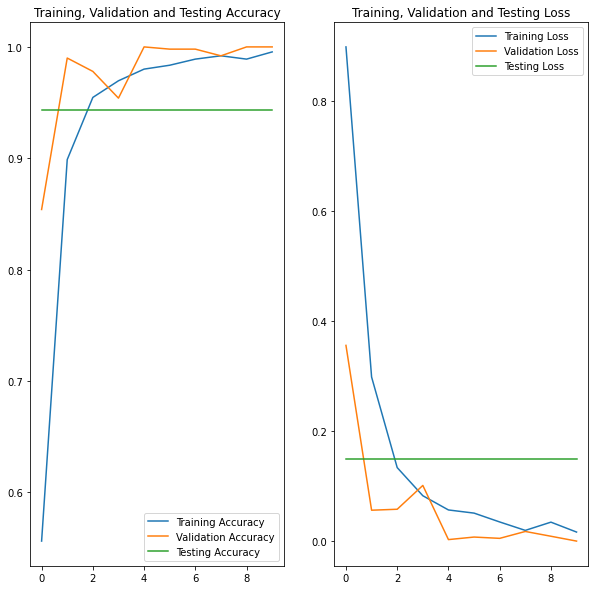

In [371]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
test_acc = results[1]

loss = history.history['loss']
val_loss = history.history['val_loss']
test_loss = results[0]

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, [test_acc]*epochs, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Training, Validation and Testing Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.plot(epochs_range, [test_loss]*epochs, label='Testing Loss')
plt.legend(loc='upper right')
plt.title('Training, Validation and Testing Loss')
plt.show()
